# Hackaton Ciencias de Redes
## Grupo 5
- #### Patricio Ramirez
- #### Carlos Bustamante
- #### Victor Ortiz
- #### Pablo Elgueta

## Tarea

#### Objetivo General: 
    Determinar patrones potenciales de corrupción en compras públicas en Chile. Para esto, se disponibilizarán los datos de todos las licitaciones públicas en Chile entre 2014 y 2021. Deben elegir un periodo a estudiar y que los datos son pesados.
    
#### 1) Análisis Exploratorio: 
    Puede incluir histogramas, relaciones bivariadas, correlaciones (coeficientes y figuras), etc.
#### 2) Inferencia red: 
    Red bipartita, proyección unimodal de la red bipartita, modelos nulos para filtrar (phi correlation, randomización preservando grado, etc)
#### 3) Descripción de la red: 
    Distribución de grados (antes y despues de filtrar), gráfico grado de nodo vs coeficiente de clustering, diámetro de la red, número de nodos, número de enlaces, densidad. Detección de comunidades, etc.
#### 4) Identifiación de patrones de corrupción en la red: 
    El trabajo es abierto en términos de identificación de patrones, sin embargo, pueden usar lo siguiente:
- 1) Índice de diversidad de simpson por comunidad (ver referencia 1)
- 2) índice de entropía del buyer (oferente) (ver referncia 2)
- 3) Licitaciones con solo 1 bider (ofertante) (ver referencia 1 y 2) [esto es uno de los indicadores de potencial
riesgo de corrupción, ver CRI referencia 2 y 3]
- 4) Coefcieinte de clustering competitivo (si trabajan con la red bipartita sin proyectar) (ver referencia 2)
- 5) Datos externos si encuentan y alcanzan son bienvenidos.
- 6) Otros.

### Importación de Librerías

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
from matplotlib import cm

# Desarrollo de Proyecto

## Objetivos e Hipotesis

- ¿Existe una relación que se repita de forma sostenida entre Organismos Públicos y Privados, con los Proveedores para el periodo a analizar?(2020).
- Desarrollo de una red bipartita para nuestro análisis.
- Trabajar en base al componente gigante de la red.
- Identificar patrones de corrupción en la red.

## 1) Análisis Exploratorio: 

    Puede incluir histogramas, relaciones bivariadas, correlaciones (coeficientes y figuras), etc.

In [2]:
df = pd.read_csv('lic2020_hackaton.csv', sep=',', encoding='latin_1')
df['FechaPublicacion']=pd.to_datetime(df['FechaPublicacion'])
df.head(3)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada


### Limpieza y Ordenamiento de Datos

- Lo primero fue analizar el contenido y eliminar aquellas filas que contuvieran datos nulos. Esto debido a que al momento de querer enlazar nodos o identificar patrones comunes estos datos quedan vinculados.

In [3]:
df.isnull().sum()

Codigo                      0
Tipo de Adquisicion         0
Estado                      0
CodigoOrganismo             0
NombreOrganismo             0
RutUnidad                   0
ComunaUnidad           111298
FechaPublicacion            0
CodigoProductoONU           0
RutProveedor                0
NombreProveedor          1860
Moneda de la Oferta         0
MontoLineaAdjudica          0
Oferta seleccionada         0
dtype: int64

In [5]:
df[df['NombreProveedor'].isnull()].head(3)
df = df.dropna()
df.isnull().sum()

Codigo                 0
Tipo de Adquisicion    0
Estado                 0
CodigoOrganismo        0
NombreOrganismo        0
RutUnidad              0
ComunaUnidad           0
FechaPublicacion       0
CodigoProductoONU      0
RutProveedor           0
NombreProveedor        0
Moneda de la Oferta    0
MontoLineaAdjudica     0
Oferta seleccionada    0
dtype: int64

### Definición de Datos a Trabajar

- De acuerdo a la informaión contenida en el dataframe, es posible identificar que claramente existen 2 grupos de nodos. Los primeros con sus datos agrupados en las columna de la izquiera corresponden a los organismos públicos que generan las licitaciones.


- En las columnas de la derecha figura lo referente a las empresas proveedoras que aprticipan de las licitaciones asociadas a los organismos públicos, estableciendose de este modo los enlaces para esta red bipartita.


- Identificados los grupos de nodos de la red bipartita, se procee a definir las columnas a utilizar de las que se extraeran estos, si utilizar códigos o  nombres. Deado que en los Organismos las cantidades de Nombres son inferiores a las de Códigos, s eopta por utilizar los nombres, ya que eventualmente podría existir mas de un Codigo asociado a los organismos, lo cual generaría una distorsión en el análisis al momento de establecer relaciones.
    

In [6]:
print('Cantidad de Nombres de Organismo:')
print(len(df['NombreOrganismo'].unique()))
print('\nCantidad de Codigos de Organismo:')
print(len(df['CodigoOrganismo'].unique()))

Cantidad de Nombres de Organismo:
859

Cantidad de Codigos de Organismo:
871


## Licitaciones Abiertas por Mes

- En general se aprecia que la distribución de licitaciones durante el año no presentó mayores variaciones entre un mes y otro, a excepción de los primeros 3 meses del año 2020 entre los meses de Enero y Marzo, sin embargo, esta variación no es significativa como para centrar incialmente un análisis en este punto.

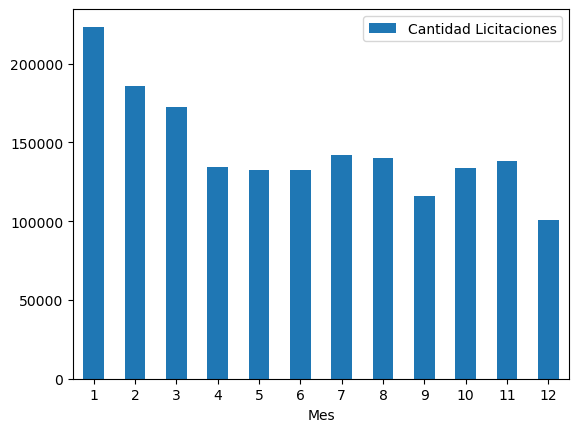

In [7]:
#Licitaciones abiertas por mes
df11 = df[df.Codigo.duplicated(keep=False)]
df11 = df11['FechaPublicacion'].dt.date.value_counts().sort_index().reset_index()
df11.columns=['Fecha Publicacion','Codigo']
df11['Fecha Publicacion']=pd.to_datetime(df11['Fecha Publicacion'])
df11['month'] = df11['Fecha Publicacion'].dt.month
df12 = df11.groupby(df11['Fecha Publicacion'].dt.month)['Codigo'].sum()
df12 = df12.to_frame().reset_index()
df12.columns = ['Mes', 'Cantidad Licitaciones']
ax = df12.plot.bar(x='Mes', y='Cantidad Licitaciones', rot=0)

In [8]:
df13 = df['NombreProveedor'].value_counts().to_frame().reset_index()
df13['NombreProveedor'].sum()

1769860

## Top Organismos con Mayores Requerimientos

- En general es posible apreciar que no existe una entidad que concentre un porcentaje de licitaciones significativamente mayor a las demás como para ser objeto de análisis.  

In [11]:
#Top Organismos ofertantes
df14['Porcentaje del total'] = df14['NombreOrganismo']/1769860
df14[:15]

,index,NombreOrganismo,Porcentaje del total
0,FUERZA AEREA DE CHILE COMANDO LOGISTICO,43210,0.024414
1,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,35290,0.019939
2,COMANDO DE APOYO A LA FUERZA,34835,0.019682
3,DIRECCION DE ABASTECIMIENTO DE LA ARMADA,26760,0.015120
4,I MUNICIPALIDAD DE LOTA,24925,0.014083
5,SERVICIO DE SALUD VALDIVIA HOSPITAL BASE,23619,0.013345
6,INSTITUTO DE SALUD PUBLICA DE CHILE,22295,0.012597
7,DIRECCION GENERAL DE GENDARMERIA DE CHIL,20607,0.011643
8,I MUNICIPALIDAD DE LA PINTANA,19980,0.011289
9,I MUNICIPALIDAD VALDIVIA,17312,0.009782


## Top Proveedores que Ofertaron a Licitación

- Tal como se aprecia en la siguiente tabla, ninguno de los proveedores concentra un alto porcentaje de participación en licitaciones como para iniciar un análisis respecto a estos valores.

In [9]:
#Top proveedores que aplicaron a licitación
df13['Porcentaje del total'] = df13['NombreProveedor']/1769860
df13[:15]

,index,NombreProveedor,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,56023,0.031654
1,Socofar Division Munnich,46353,0.026190
2,Caribean Pharma Ltda,43473,0.024563
3,Distribuidora Salcobrand,36489,0.020617
4,WINPHARM,34765,0.019643
5,Medikar Ltda,30318,0.017130
6,DROGUERIA GLOBAL PHARMA SPA,29200,0.016498
7,LABOFAR,22592,0.012765
8,COMERCIALIZADORA ILHABELLA EIRL,22505,0.012716
9,LABORATORIO CHILE S.A.,20346,0.011496


In [10]:
df14 = df['NombreOrganismo'].value_counts().to_frame().reset_index()
df14['NombreOrganismo'].sum()

1769860

## Top Proveedores Seleccionados

- Dentro de los proveedores con mayor cantidad de adjudicaciones se aprecia que predominan aquellos vinculados a la farmaceutica. Sin embardo, individualmente ninguno arroja un porcentaje lo suficientemente grande apra ser objeto de análisis.

In [12]:
df15 = df['Oferta seleccionada'].value_counts().to_frame().reset_index()
df15

,index,Oferta seleccionada
0,No Seleccionada,1409938
1,Seleccionada,359922


In [13]:
#Top proveedores seleccionados
df15 = df[df['Oferta seleccionada'] == 'Seleccionada']
df15 = df15['NombreProveedor'].value_counts().to_frame().reset_index()
df15['Porcentaje del total'] = df15['NombreProveedor']/359922
df15[:15]

,index,NombreProveedor,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,8624,0.023961
1,Caribean Pharma Ltda,7468,0.020749
2,Socofar Division Munnich,6066,0.016854
3,LABORATORIO CHILE S.A.,5974,0.016598
4,LABORATORIOS RECALCINE S.A,4870,0.013531
5,DROGUERIA GLOBAL PHARMA SPA,4756,0.013214
6,VALTEK S.A.,3833,0.010650
7,LABORATORIOS ANDROMACO S.A.,3245,0.009016
8,Distribuidora Salcobrand,3156,0.008769
9,MAYORDENT LTDA,3082,0.008563


In [14]:
df16 = df['Estado'].value_counts().to_frame().reset_index()
df16

,index,Estado
0,Adjudicada,1633154
1,Desierta (o art. 3 ó 9 Ley 19.886),75018
2,Revocada,32108
3,Cerrada,29503
4,Suspendida,77


In [15]:
df16 = df[df['Estado'] == 'Adjudicada']
df16 = df16['NombreProveedor'].value_counts().to_frame().reset_index()
df16['Porcentaje del total'] = df16['NombreProveedor']/1633154
df16[:15]

,index,NombreProveedor,Porcentaje del total
0,ETHON PHARMACEUTICALS SPA.,53671,0.032863
1,Socofar Division Munnich,43958,0.026916
2,Caribean Pharma Ltda,41971,0.025699
3,Distribuidora Salcobrand,35137,0.021515
4,WINPHARM,33047,0.020235
5,Medikar Ltda,29319,0.017952
6,DROGUERIA GLOBAL PHARMA SPA,28048,0.017174
7,LABOFAR,21815,0.013358
8,COMERCIALIZADORA ILHABELLA EIRL,20891,0.012792
9,LABORATORIO CHILE S.A.,19765,0.012102


## 2) Inferencia red:

    Red bipartita, proyección unimodal de la red bipartita, modelos nulos para filtrar (phi correlation, randomización preservando grado, etc)

## Definición de Nodos y Enlaces

#### Lista de Nodos de Organismos

In [16]:
lista_organismos = df['NombreOrganismo'].unique()
lista_organismos[0:5]
len(lista_organismos)

859

#### Lista de Nodos de Empresas

In [17]:
lista_empresas = df['NombreProveedor'].unique()
lista_empresas[0:5]
len(lista_empresas)

37765

#### Eliminar Nodos Presentes en Ambos Grupos de Nodos



- Como el objetivo es construir una Red Bipartita, se identifican aquellas empresas que participan como oferentes y que también se en cuentran dentro del listado de Organismos. Estas corresponden a aquellas empresas estatales como universidades, las cuales poseen áreas de proyectos o investigación para el autofinanciamiento.

In [18]:
del_empresas = []
for organismo in lista_organismos:
    for empresa in lista_empresas:
        if organismo == empresa:
            del_empresas.append(organismo)
del_empresas

['UNIVERSIDAD DE MAGALLANES',
 'UNIVERSIDAD DEL BIO BIO',
 'UNIVERSIDAD DE ATACAMA',
 'UNIVERSIDAD DE TALCA',
 'UNIVERSIDAD DE LA FRONTERA',
 'INSTITUTO FORESTAL',
 'INSTITUTO DE FOMENTO PESQUERO']

In [19]:
for universidad in del_empresas:
    df = df[df['NombreProveedor'] != universidad]

lista_empresas = df['NombreProveedor'].unique()
len(lista_empresas)

#### Definición de Enlaces Empresas/Organismos

In [21]:
pivot = pd.pivot_table(df, index=['NombreOrganismo','NombreProveedor'],values=['Oferta seleccionada'],aggfunc='count')
pivot = pivot.reset_index()
pivot.head()

,NombreOrganismo,NombreProveedor,Oferta seleccionada
0,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,ARTL CHILE AUDITORES SPA,1
1,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,AdjudicaChile Consultora en Licitaciones Públicas,1
2,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Aiguasol,2
3,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Amelia Virginia,1
4,AGENCIA CHILENA DE COOPERACION INTERNACIONAL P...,Astral S.A.,1


In [22]:
lista_tuplas_pesos = []

for i in pivot.to_numpy():
    lista_tuplas_pesos.append((i[0], i[1], i[2]))
lista_tuplas_pesos[:4]

[('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'ARTL CHILE AUDITORES SPA',
  1),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'AdjudicaChile Consultora en Licitaciones Públicas',
  1),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'Aiguasol',
  2),
 ('AGENCIA CHILENA DE COOPERACION INTERNACIONAL PARA EL DESARROLLO',
  'Amelia Virginia',
  1)]

In [23]:
len(lista_tuplas_pesos)

205391

## Construcción del Grafo

- Se realiza la construcción del Grafo y se verifica que la red construida sea bipartita

In [24]:
G = nx.Graph()
G.add_nodes_from(lista_empresas, bipartite=0)
G.add_nodes_from(lista_organismos,bipartite=1)
G.add_weighted_edges_from(lista_tuplas_pesos)
bipartite.is_bipartite(G)

True

## 3) Descripción de la red: 
    Distribución de grados (antes y despues de filtrar), gráfico grado de nodo vs coeficiente de clustering, diámetro de la red, número de nodos, número de enlaces, densidad. Detección de comunidades, etc.

## Numero de Nodos y Enlases, Grado Promedio, Grado Mínimo y Grado Máximo

In [26]:
N1 = len(G)
L1 = G.size()
degrees1 = list(dict(G.degree()).values())
kmin1 = min(degrees1)
kmax1 = max(degrees1)

print("Número de nodos: ", N1)
print("Número de enlaces: ", L1)
print('-------')
print("Grado promedio: ", 2*L1/N1) #Formula vista en clases (qué sucedía con las redes reales?)
print("Grado promedio (alternativa de calculo)", np.mean(degrees1))
print('-------')
print("Grado mínimo: ", kmin1)
print("Grado máximo: ", kmax1)

Número de nodos:  38617
Número de enlaces:  205391
-------
Grado promedio:  10.637335888339333
Grado promedio (alternativa de calculo) 10.637335888339333
-------
Grado mínimo:  1
Grado máximo:  3165


## Densidad de la Red

- Es posible apreciar que la densidad de la red es bastante baja, lo cual también permite inferir que la red poseera varias comunidades entre las cuales se relacionen los nodos.

In [48]:
print(f'Densidad: {nx.density(G)}')

Densidad: 0.00027546446779416127


## Gráficos de Distribución de Grado
- El análisis mediante histogramas permite confirmar nuevamente que existe una gran cantidad de nodos bajamente conectados y que para grados mayores la distribución de nodos disminuye exponencialmente.

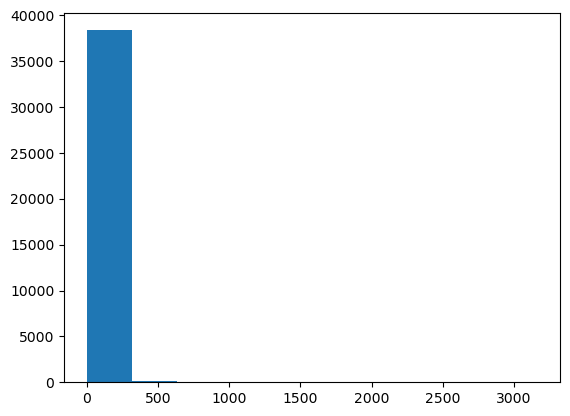

In [27]:
degrees = list(dict(G.degree()).values())
plt.hist(list(degrees))
plt.show()

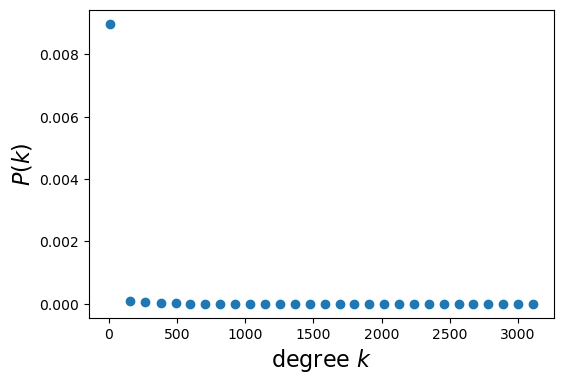

In [28]:
# Entrega 20 bins linealmente espaceados entre kmin y kmax
bin_edges = np.linspace(kmin1, kmax1, num=30)

# histograma de la data en estos bines 
density, _ = np.histogram(degrees1, bins=bin_edges, density=True)
###Histograma
fig = plt.figure(figsize=(6,4))

# "x" debería ser el punto medido (en escala lineal) de cada bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Muestra la gráfica
plt.show()

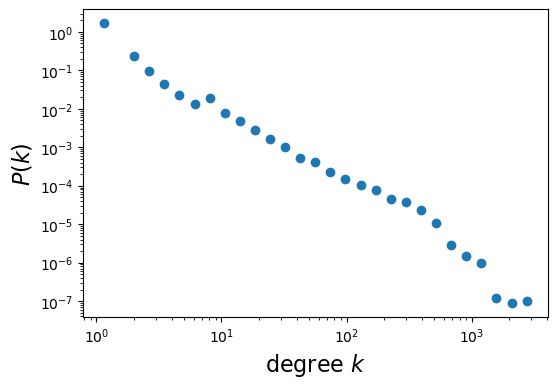

In [29]:
bin_edges = np.logspace(np.log10(kmin1), np.log10(kmax1), num=30)
density, _ = np.histogram(degrees1, bins=bin_edges, density=True)
np.histogram(degrees1, bins=bin_edges, density=True)

###Histograma
fig = plt.figure(figsize=(6,4))

# "x" debe ser el punto medio (en escala LOG) de cada bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# Muestra la gráfica
plt.show()

## Detección de Comunidades

- Tal como era posible predecir debido a lo poco densa de la red, existe una cantidad significativa de comunidades.


- En este punto se ha optado por definir un random_state para la función de best_partition que arroje una partición con varias comunidades de baja cantidad de nodos, a fin de facilitar el análisis de las comunidades mediante algoritmos.

In [164]:
from community import community_louvain

partition = community_louvain.best_partition(G, weight='weight', random_state = 6)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Se detectan 15 comunidades


Tamaño Comunidad 0: 3014
Tamaño Comunidad 1: 3273
Tamaño Comunidad 2: 7983
Tamaño Comunidad 3: 8138
Tamaño Comunidad 4: 52
Tamaño Comunidad 5: 70
Tamaño Comunidad 6: 4884
Tamaño Comunidad 7: 701
Tamaño Comunidad 8: 4515
Tamaño Comunidad 9: 2314
Tamaño Comunidad 10: 4
Tamaño Comunidad 11: 2926
Tamaño Comunidad 12: 732
Tamaño Comunidad 13: 5
Tamaño Comunidad 14: 6


## Nota:

###### Dado que correr el código nx.spring_layout(G) tarda demaciado tiempo, se ha generado un código que permite importar ya la disposición de nodos desde un archivo CSV.  

###### Se recomienda desactivar o eliminar los siguientes códicos si el programa ya ha sido ejecutado previamente y el archivo CSV ha sido generado, a fin de agilizar su ejecución:


- pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)
- pos_export = pd.DataFrame(pos)
- pos_export.to_csv('TareaFinalPos.csv')

In [31]:
# pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)
# pos_export = pd.DataFrame(pos)
#pos_export.to_csv('TareaFinalPos.csv')
pos_import = pd.read_csv('TareaFinalPos.csv', sep=',')
pos_import = pos_import.drop(['Unnamed: 0'], axis=1)
cord_dict = {}
for key in pos_import:
    cord = [pos_import[key][0], pos_import[key][1]]
    cord = np.array(cord)
    cord_dict[key] = cord
    
pos_import = cord_dict

#### Validación de Tamaños Coincidentes en los Datos

In [32]:
#Posiciones definidas para los nodos
len(pos_import)

38617

In [33]:
#Verificacion de cantidad de nodos
len(lista_organismos)+len(lista_empresas)

38617

In [34]:
#Corroborar que la suma de cada nodo separado en als comunidades coincidan con la cantidad de nodos

sum = int()
for i in range(len(d)):
    sum = sum + len(d[i])
print (sum)

38617


## Ploteo del Grafo

- Mediante el gráfico de red, es posible notar que si bien existen comunidades pegueñas que se notan aisladas en la periferia, también es posible apreciar que las comunidades mas grandes no son facilmente separables entre si, por lo cual se deduce que la partición debe poseer una baja modularidad.

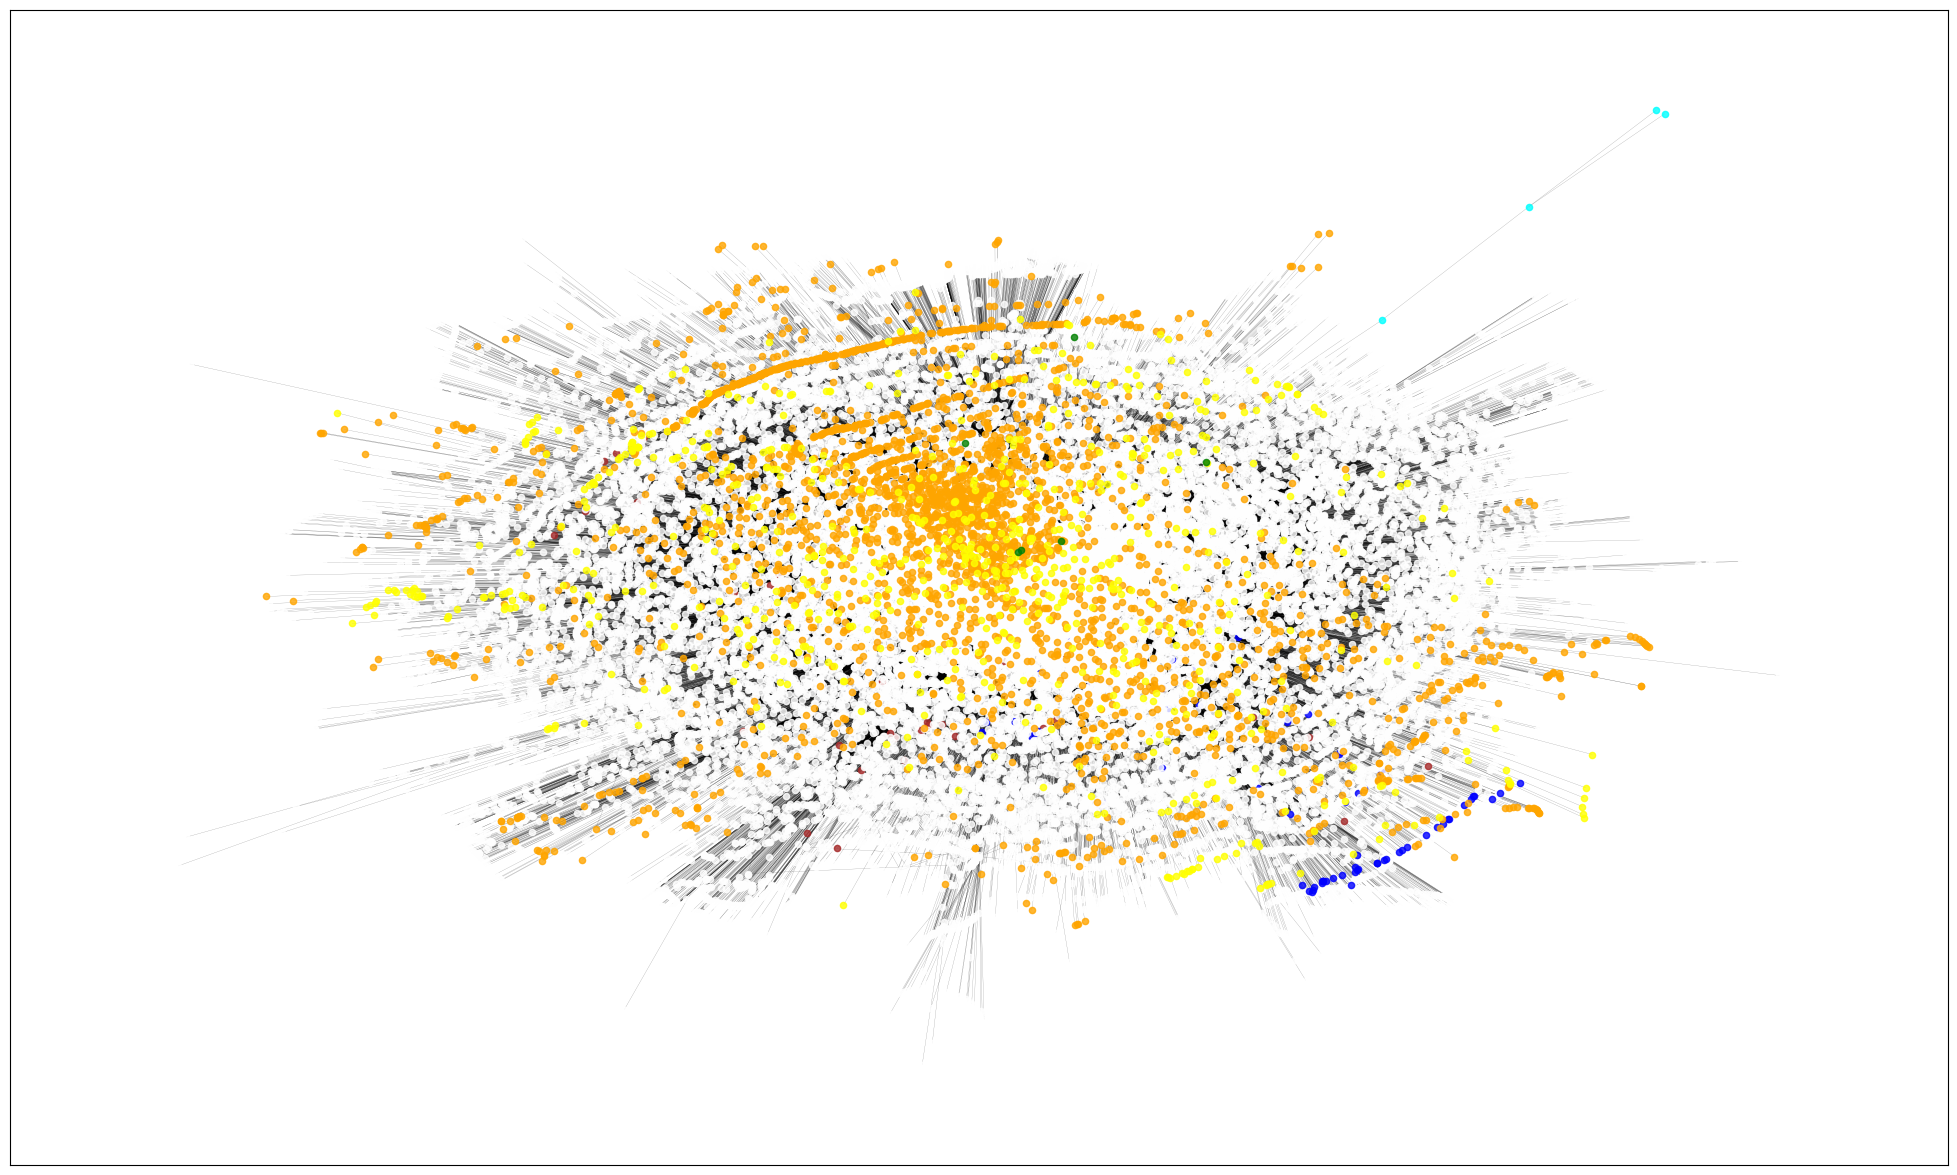

In [52]:
plt.figure(figsize=(25, 15))

#colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
colors = ['white', 'white', 'white', 'white', 'brown', 'blue', 'white', 'white', 'white', 'white', 'cyan', 'orange', 'yellow', 'white', 'green', 'red', ]

count = 0
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos_import, list_nodes, node_size = 20, node_color=colors[count], alpha=0.8)#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores

nx.draw_networkx_edges(G, pos_import, alpha=0.5, width=0.15)#plotea enlaces
plt.show()


## 4) Identifiación de patrones de corrupción en la red: 
    El trabajo es abierto en términos de identificación de patrones, sin embargo, pueden usar lo siguiente:
- 1) Índice de diversidad de simpson por comunidad (ver referencia 1)
- 2) índice de entropía del buyer (oferente) (ver referncia 2)
- 3) Licitaciones con solo 1 bider (ofertante) (ver referencia 1 y 2) [esto es uno de los indicadores de potencial
riesgo de corrupción, ver CRI referencia 2 y 3]
- 4) Coefcieinte de clustering competitivo (si trabajan con la red bipartita sin proyectar) (ver referencia 2)
- 5) Datos externos si encuentan y alcanzan son bienvenidos.
- 6) Otros.

In [36]:
# Función para separar las comunidades y graficarlas individualmente
def comunidad(df, d):

    df2 = pd.DataFrame()
    j = 0
    for i in range (len(df)):
        if df.NombreOrganismo[i] in d:
            if j == 0:
                df2 = df.loc[i:i]
                j = 1
            else:
                df3 = df.loc[i:i]
                frames = [df2,df3]
                df2 = pd.concat(frames)
    df2 = df2.reset_index()
    
    j = 0
    for i in range (len(df2)):
        if df2.NombreProveedor[i] in d:
            if j == 0:
                df1 = df2.loc[i:i]
                j = 1
            else:
                df3 = df2.loc[i:i]
                frames = [df1,df3]
                df1 = pd.concat(frames)
    df1 = df1.reset_index()                        
    df1 = df1[['NombreOrganismo','NombreProveedor','Oferta seleccionada']]
    
    lista_tuplas_pesos = []
    for i in df1.to_numpy():
        lista_tuplas_pesos.append((i[0], i[1], i[2]))
    lista_tuplas_pesos[:4]

    G = nx.Graph()
    G.add_nodes_from(df1['NombreProveedor'].unique(), bipartite=0)
    G.add_nodes_from(df1['NombreOrganismo'].unique(),bipartite=1)
    G.add_weighted_edges_from(lista_tuplas_pesos)
    
    plt.figure(figsize=(10, 6))
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, d, node_size = 20, node_color=['red'], alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.8, width=0.25)

    plt.show()
            
    return df1, G

In [103]:
# Funcion para crear lista de codigos de licitacion entre un par organismo-proveedor

def lista_empresa_licitacion(nombre_organismo, nombre_proveedor):
    
    df_ddn = df[['Codigo','NombreOrganismo','NombreProveedor','Oferta seleccionada']]
    df_ddn = df_ddn[(df_ddn['NombreProveedor'] == nombre_proveedor) ]
    
    lista_codigos = []

    for i in df_ddn['Codigo'].to_numpy():
        lista_codigos.append(i)
       
    return lista_codigos

# Funcion para conseguir el coeficiente de jaccard

def jaccard(grupo1, grupo2):
    interseccion = len(set(grupo1).intersection(set(grupo2)))
    union = len (set(grupo1).union(set(grupo2)))
    
    return interseccion / union , interseccion

# Funcion para conseguir el coeficiente de jaccard para todos los nodos dentro de una comunidad

def jaccard_completo(dd):
    
    lista_nombres_organismos = dd['NombreOrganismo']
    lista_nombres_proveedores = dd['NombreProveedor']
    
    dicc_codigos_dd = {}
    
    df = pd.DataFrame(columns=['NombreProveedor_1', 'NombreProveedor_2', 'Coeficiente de Jaccard', 'CantidadCoincidencias'])
    
    for i in range(len(dd)):
        lista_codigos = lista_empresa_licitacion(lista_nombres_organismos[i], lista_nombres_proveedores[i])
        
        dicc_codigos_dd[lista_nombres_proveedores[i]] = lista_codigos
                
    for key_j, value_j in dicc_codigos_dd.items():
        for key_k, value_k in dicc_codigos_dd.items():
            jacard_empresas, interseccion = jaccard(value_j, value_k)
            #print (f"Porcentaje de similitud Para Empresas {key_j} y {key_k} : {round(jacard_empresas,2)}")
            df_append = pd.DataFrame({'NombreProveedor_1': key_j, 'NombreProveedor_2': key_k,
                                      'Coeficiente de Jaccard': round(jacard_empresas,2), 'CantidadCoincidencias':interseccion }, index=[0])
            frames = [df, df_append]
            df = pd.concat(frames)
            
    df = df.sort_values(by='Coeficiente de Jaccard', ascending=False)
    df = df.reset_index().drop(columns='index')
    
    for index, row in df.iterrows():
        if row['NombreProveedor_1'] == row['NombreProveedor_2']:
            df = df.drop(index)
    df = df.reset_index().drop(columns='index')
    df2 = df
    for i in range(len(df2)):
        for k in range(i+1, len(df2)):
            
            if df2.NombreProveedor_1[i] == df2.NombreProveedor_2[k]: 
                if df2.NombreProveedor_1[k] == df2.NombreProveedor_2[i]:
                    df = df.drop(k)
        
    return df    

## Comunidad de Estudio 0


- Para esta comunidad se han realizado 2 análisis, el primero mediante la representación gráfica de la red bipartita y la tabla de enlases poderados. Este análisis tiene como objetivo definir si existe algun tipo de vinculación entre el Organismos licitador y las empresas de Proveedores. 


- El segundo es el cálculo del Coeficiente de Jaccar el cual busca identificar la razón de coincidencias entre las licitaciones en que participan los nodos de la comunidad. 

#### Grafo y Tabla de Enlases de Comunidad

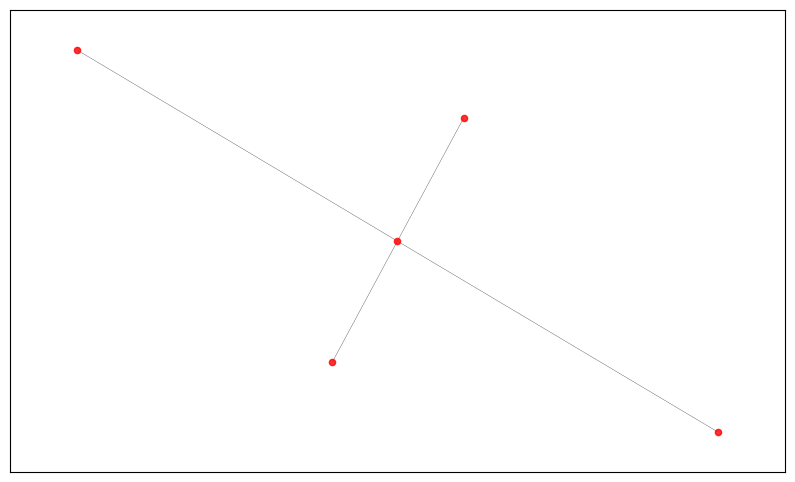

,NombreOrganismo,NombreProveedor,Oferta seleccionada
1,GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,11
2,GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,11
0,GOBIERNO REGIONAL DE ATACAMA,Aquapress Limitada,1
3,GOBIERNO REGIONAL DE ATACAMA,Zerega Y Cia. Ltda.,1


In [38]:
dd0,Gd0 = comunidad(pivot, d[13])
dd0.sort_values(by='Oferta seleccionada', ascending=False)

- Mediante este análisis es posible identificar que en existe una llamativa distribución en las participaciones dentro de esta comunidad donde de un total de 25 participaciones en licitaciones, correspondientes a solo 2 códigos con y con un total de 12 OC emitidas. 

In [105]:
df0 = df[df['NombreOrganismo'] == 'GOBIERNO REGIONAL DE ATACAMA']
df0 = df0[['Codigo','Tipo de Adquisicion','NombreOrganismo','NombreProveedor','MontoLineaAdjudica','Moneda de la Oferta']]
df0

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
475059,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,15000,Peso Chileno
475060,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475061,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475062,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,18000,Peso Chileno
475063,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,20000,Peso Chileno
475064,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475065,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno
475066,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,25000,Peso Chileno
475067,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,GYP TECNOLOGIA,18000,Peso Chileno
475068,8748588,Licitación Pública Entre 100 y 1000 UTM (LE),GOBIERNO REGIONAL DE ATACAMA,Conecta Global Ltda.,0,Peso Chileno


In [101]:
df0[df0['Codigo']== 8748588]['MontoLineaAdjudica'].astype('int64', copy=False).sum()

355400

- Dentro de las 12 OC emitidas por el Gobierno Regional de Atacama, 11 son a GYP TECNOLOGIA	 con un valor total de $355.400, y cuyo proceso de licitación solo contó con un oferente adicional.


- Respecto a la OC restante, en su proceso de licitación solo participaron 3 oferentes y el proveedor adjudicado fue Zerega Y Cia. Ltda. por un monto de $19.800.000

#### Coeficiente de Jaccar

In [104]:
codigos0 = jaccard_completo(dd0)
codigos0 = codigos0[codigos0['CantidadCoincidencias']>0.5*codigos0['CantidadCoincidencias'].max()]
codigos0

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,Aquapress Limitada,Zerega Y Cia. Ltda.,1.0,1
2,Conecta Global Ltda.,GYP TECNOLOGIA,0.5,1


- Este indicador permite identificar que en el caso de "Aquapress Limitada" y "Zerega Y Cia. Ltda." dentro de los registros solo poseen una única participación en licitaciones y corresponde a la del Gobierno Regional de Atacama.


- Si bien ambos procesos de adjudicación parecen llamativos, en el caso de la licitación 8682225 adjudicada a "Zerega Y Cia. Ltda." es mucho más llamativo ya que por un lado la licitación posee muy pocos oferentes y 2 de ellos presentan solo una única participación lo cual podría ser indicio de colusión o de participantes que solo buscaban completar la terna para que la licitación no sea declarada desierta.



## Comunidad de Estudio 1

#### Grafo y Tabla de Enlases de Comunidad

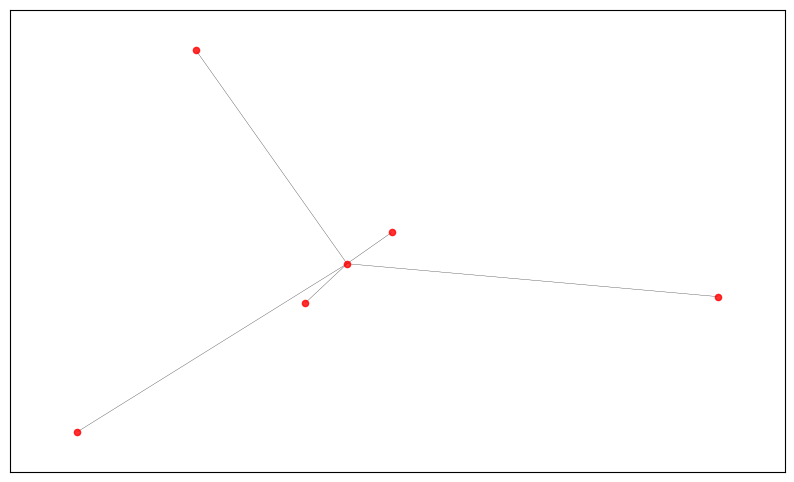

,NombreOrganismo,NombreProveedor,Oferta seleccionada
2,HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,64
3,HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,50
0,HOSPITAL PADRE ALBERTO HURTADO,AIR CENTRAL SPA,1
1,HOSPITAL PADRE ALBERTO HURTADO,APO Limitada,1
4,HOSPITAL PADRE ALBERTO HURTADO,barbara michele,1


In [40]:
dd1,Gd1 = comunidad(pivot, d[14])
dd1.sort_values(by='Oferta seleccionada', ascending=False)

- En este caso, se aprecia una comunidad en torno al "HOSPITAL PADRE ALBERTO HURTADO" en torno a la cual se han detectado 5 nodos con un total de 117 ofertas realizadas.

In [129]:
df1 = df[df['NombreOrganismo'] == 'HOSPITAL PADRE ALBERTO HURTADO'][df['Oferta seleccionada']=='Seleccionada']
df1 = df1[['Codigo','Tipo de Adquisicion','NombreOrganismo','NombreProveedor','MontoLineaAdjudica','Moneda de la Oferta']]
df1.head(5)

C:\Users\pablo\AppData\Local\Temp\ipykernel_15052\2010519581.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df['NombreOrganismo'] == 'HOSPITAL PADRE ALBERTO HURTADO'][df['Oferta seleccionada']=='Seleccionada']


,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
437045,8745122,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PADRE ALBERTO HURTADO,HOSER INGENIERIA,83990000,Peso Chileno
588959,8757674,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Mapfre Seguros de Chile S.A.,45975278,Unidad de Fomento
957863,8670408,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,MEGALABS CHILE SA MEDICAL DEVICE,4800,Peso Chileno
957864,8670408,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Global Healthcare Chile L.P.,564000,Peso Chileno
957866,8670408,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Allmedica S.A,870000,Peso Chileno


In [121]:
len(df1)

89

- El "HOSPITAL PADRE ALBERTO HURTADO" realizó durante el año 2020 un total de 89 adjudicaciones de OC.

In [119]:
df1[df1['NombreProveedor'] == 'PAB Ingeniería'].head(5)

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
1529424,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,3890,Peso Chileno
1529425,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,3890,Peso Chileno
1529430,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,3890,Peso Chileno
1529437,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,35625,Peso Chileno
1529443,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,PAB Ingeniería,1782,Peso Chileno


In [115]:
len(df1[df1['NombreProveedor'] == 'PAB Ingeniería'])

38

- Dentro de la comunidad en análisis el nodo con mayor cantidad de adjudicaciones corresponde a "PAB Ingeniería", con 38 de las 89 adjudicaciones realizadas por el hospital.

In [117]:
df1[df1['NombreProveedor'] == 'PAB Ingeniería']['MontoLineaAdjudica'].astype('int64', copy=False).sum()

642867

- Estas adjudicaciones suman un total de $642.867, lo cual no representa un monto elevado.

#### Coeficiente de Jaccar

In [109]:
codigos1 = jaccard_completo(dd1)
codigos1[codigos1['CantidadCoincidencias']>0.5*codigos1['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,barbara michele,APO Limitada,0.5,1
2,PAB Ingeniería,Valeska Solange,0.5,1


In [131]:
df1[df1['NombreProveedor'] == 'Valeska Solange'].head(5)

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
1529433,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,3100,Peso Chileno
1529434,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,1500,Peso Chileno
1529440,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,1500,Peso Chileno
1529449,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,2200,Peso Chileno
1529450,8703857,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Valeska Solange,2500,Peso Chileno


- Dentro de los nodos con mayor coeficiente de Jaccar se encuentran "PAB Ingeniería" y "Valeska Solange" con un indice de 0.5, sin embargo, se descarta algún tipo de colusión ya que ambas empresas coincidieron unicamente en la licitación 8703857 dividida en varias adjudicaciones donde cada uno de los proveedores tuvo adjudicaciones.

In [124]:
df1[df1['NombreProveedor'] == 'APO Limitada'].head(5)

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta


In [132]:
df1[df1['NombreProveedor'] == 'barbara michele'].head(5)

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta


- Respecto a los otros nodos con un indice de Jaccar reelevante, "APO Limitada" y "barbara michele", ninguno de los 2 posee adjudicaciones por lo que no proporcionan mayores antecedentes.

In [127]:
df1 = df[df['NombreOrganismo'] == 'HOSPITAL PADRE ALBERTO HURTADO']
df1 = df1[['Codigo','Tipo de Adquisicion','NombreOrganismo','NombreProveedor','MontoLineaAdjudica','Moneda de la Oferta']]


,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
437043,8745122,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PADRE ALBERTO HURTADO,Andover Alianza Médica S. A.,0,Peso Chileno
437044,8745122,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PADRE ALBERTO HURTADO,Datamedica S.A.,0,Peso Chileno
437045,8745122,Licitación Pública Mayor 1000 UTM (LP),HOSPITAL PADRE ALBERTO HURTADO,HOSER INGENIERIA,83990000,Peso Chileno
588959,8757674,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Mapfre Seguros de Chile S.A.,45975278,Unidad de Fomento
957860,8670408,Licitación Pública Entre 100 y 1000 UTM (LE),HOSPITAL PADRE ALBERTO HURTADO,Mediplex,0,Peso Chileno


In [128]:
len(df1)

269

- A diferencia de lo ocurrido en la Comunidad de Estudio 0, en el caso de la Comunidad de Estudio 1 no nos proporciona mayor información a posibles casos de corrupción.


- Lo anterior, puede ser atribuido a que si bien existe una comunidad de nodos fuertemente relacionados con el Hospital Padre Alberto Hurtado, en realidad estos solo representan una porción menor del total de ofertas presentadas por proveedores a dicho hospital, 117 de 269, por lo cual en realidad existe mayor competencia aparte de la que conforman los nodos de esta comunidad.

## Comunidad de Estudio 2

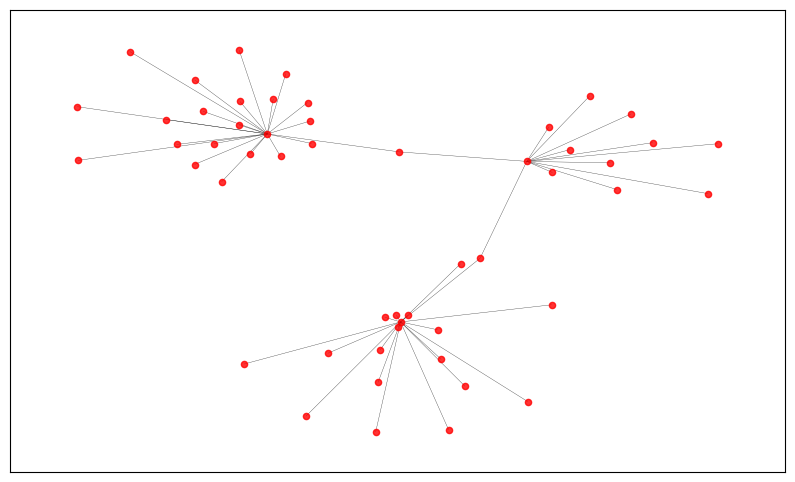

,NombreOrganismo,NombreProveedor,Oferta seleccionada
15,I MUNICIPALIDAD DE FREIRINA,ferrohogar,435
9,I MUNICIPALIDAD DE FREIRINA,Ferretería Lonza y Cía. Ltda.,380
5,I MUNICIPALIDAD DE FREIRINA,Carlos Carrasco,374
2,I MUNICIPALIDAD DE FREIRINA,BRENDA ARACELY,229
12,I MUNICIPALIDAD DE FREIRINA,Multy,21
40,SERVICIO DE SALUD NUBLE HOSPITAL DE QUIRIHUE,GUSTAVO GALLEGOS,18
33,I MUNICIPALIDAD DE HUALAIHUE,María José,16
20,I MUNICIPALIDAD DE HUALAIHUE,BRAULIO RODRIGO,16
43,SERVICIO DE SALUD NUBLE HOSPITAL DE QUIRIHUE,HECTOR HERNAN,15
34,I MUNICIPALIDAD DE HUALAIHUE,OLEA SERVICIOS SPA,15


In [42]:
dd2,Gd2 = comunidad(pivot, d[4])
dd2.sort_values(by='Oferta seleccionada', ascending=False)

In [171]:
df2 = df[df['NombreOrganismo'] == 'I MUNICIPALIDAD DE FREIRINA'][df['Oferta seleccionada']=='Seleccionada']
df2 = df2[['Codigo','Tipo de Adquisicion','NombreOrganismo','NombreProveedor','MontoLineaAdjudica','Moneda de la Oferta']]
df2.head(5)

C:\Users\pablo\AppData\Local\Temp\ipykernel_15052\3895269454.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df[df['NombreOrganismo'] == 'I MUNICIPALIDAD DE FREIRINA'][df['Oferta seleccionada']=='Seleccionada']


,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
137667,8642524,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ESPEX INGENIERIA,5040000,Peso Chileno
152677,8643557,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,C.A Producciones,"4,4e+07",Peso Chileno
344168,8737637,Licitación Pública entre a 2000 y 5000 UTM (LQ),I MUNICIPALIDAD DE FREIRINA,Emigdio H. Venegas Cereceda,108406250,Peso Chileno
348921,8738265,Licitación Pública Mayor 1000 UTM (LP),I MUNICIPALIDAD DE FREIRINA,Javier Alejandro,49616875,Peso Chileno
512621,8752907,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,CA PRODUCCIONES,8193277,Peso Chileno


In [172]:
len(df2)

763

In [176]:
df2[df2['NombreProveedor'] == 'ferrohogar']

,Codigo,Tipo de Adquisicion,NombreOrganismo,NombreProveedor,MontoLineaAdjudica,Moneda de la Oferta
1059888,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1059889,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1059895,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1059900,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1059901,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
...,...,...,...,...,...,...
1061062,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1061065,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1061066,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno
1061067,8675381,Licitación Pública Entre 100 y 1000 UTM (LE),I MUNICIPALIDAD DE FREIRINA,ferrohogar,1,Peso Chileno


In [177]:
df2['MontoLineaAdjudica'].astype('int64', copy=False).sum()

ValueError: invalid literal for int() with base 10: '4,4e+07'

In [139]:
lista_tuplas_pesos_2 = []

for i in dd2.to_numpy():
    lista_tuplas_pesos_2.append((i[0], i[1], i[2]))
lista_tuplas_pesos_2[:4]

[('I MUNICIPALIDAD DE FREIRINA', '783960508', 1),
 ('I MUNICIPALIDAD DE FREIRINA', 'ATACAMA PRO SPORT', 5),
 ('I MUNICIPALIDAD DE FREIRINA', 'BRENDA ARACELY', 229),
 ('I MUNICIPALIDAD DE FREIRINA', 'CA PRODUCCIONES', 1)]

In [158]:
partition2 = community_louvain.best_partition(Gd2, weight='CantidadCoincidencias', random_state = 9)

size = (len(set(partition2.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

dGd2 = {}
for character, par in partition2.items():
    if par in dGd2:
        dGd2[par].append(character)
    else:
        dGd2[par] = [character]

for i in range(len(dGd2)):
    print(f'Tamaño Comunidad {i}: {len(dGd2[i])}')

Se detectan 3 comunidades


Tamaño Comunidad 0: 18
Tamaño Comunidad 1: 21
Tamaño Comunidad 2: 13


In [155]:
def weighted_degree(Graph, weight):

    d = {}        
    for i in range(0,len(list(Graph.edges()))):
        v = list(Graph.edges(data=True))[i]
        
        if v[0] in d:
            d[v[0]] += v[2][weight]
            
        else:
            d[v[0]] = v[2][weight]

    k = {}
    
    for i, j in dict(nx.degree(Graph)).items():
        
        k[i] = j
        
    for i, j in k.items():
        for k, l in d.items():
            if k == i:
                d[k] = l/j
        
    return d
    #print((sorted(d.items(), key=lambda x:x[1], reverse=True)[:]))
    #print((sorted(d.items(), key=lambda x:x[1], reverse=True)[:5]))

In [160]:
weighted_degree(Gd2, 'weight')

{'783960508': 1.0,
 'ATACAMA PRO SPORT': 5.0,
 'BRENDA ARACELY': 229.0,
 'CA PRODUCCIONES': 1.0,
 'CONGLO SPA': 3.0,
 'Carlos Carrasco': 374.0,
 'ENTEL CHILE S.A. - Gerencia Zonal Iquique': 4.0,
 'Eduardo Osciel': 1.0,
 'Emigdio H. Venegas Cereceda': 1.0,
 'Ferretería Lonza y Cía. Ltda.': 380.0,
 'Hugo': 2.0,
 'INFORME REMOTO LIMITADA': 3.0,
 'Multy': 21.0,
 'PabloSmith': 12.0,
 'WILLIAMS ALIS MADARIAGA VALDIVIA': 1.0,
 'ferrohogar': 435.0,
 'francollaodvet': 1.0,
 'nivaldo olivares lopez': 1.0,
 'AAAGALLARDO': 1.0,
 'ALVEAL121': 10.0,
 'BRAULIO RODRIGO': 16.0,
 'Construtecnia Chile': 1.0,
 'Daniel Leonardo': 8.0,
 'ESTEBAN MAURICIO': 5.0,
 'El Buen Gourmet Ltda.': 4.0,
 'El navegador': 5.0,
 'FERRETERIA EL CONSTRUCTOR': 2.0,
 'FUNERARIA CASANOVA': 8.0,
 'Geordy Heinrich': 10.0,
 'HECTOR HERNAN': 15.0,
 'JOSE JAIME': 6.0,
 'KEMELBUS': 3.0,
 'LMSA SPA': 4.0,
 'María José': 16.0,
 'OLEA SERVICIOS SPA': 15.0,
 'RUPERTO RAUL': 8.0,
 'Ruth Amada': 8.0,
 'SALAZAR721': 1.0,
 'farmacia austral

In [161]:
Nodo_Importnant = pd.DataFrame()
Nodo_Importnant["Book_1"] = pd.DataFrame(sorted(weighted_degree(Gd2,'weight').items(), key=lambda x:x[1], reverse=True)[0:5]).loc[:,:0]
pd.DataFrame(sorted(weighted_degree(Gd2,'weight').items(), key=lambda x:x[1], reverse=True)[0:5]) 

,0,1
0,ferrohogar,435.0
1,Ferretería Lonza y Cía. Ltda.,380.0
2,Carlos Carrasco,374.0
3,BRENDA ARACELY,229.0
4,Multy,21.0


In [107]:
codigos2 = jaccard_completo(dd2)
codigos2[codigos2['CantidadCoincidencias']>0.9*codigos2['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
0,BRAULIO RODRIGO,María José,1.00,2
6,BRAULIO RODRIGO,ALVEAL121,0.67,2
7,ALVEAL121,María José,0.67,2
26,Hugo,ENTEL CHILE S.A. - Gerencia Zonal Iquique,0.22,2
48,HECTOR HERNAN,El navegador,0.08,2


## Comunidad de Estudio 3

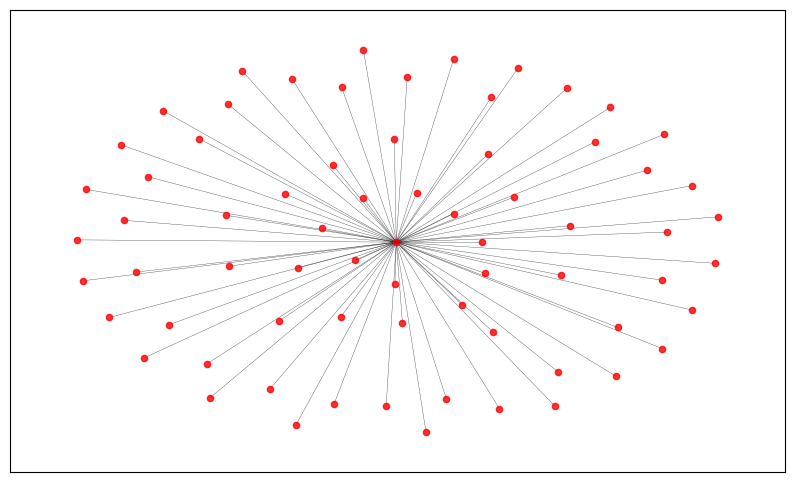

,NombreOrganismo,NombreProveedor,Oferta seleccionada
53,I MUNICIPALIDAD DE CHEPICA,VIDALFA LIMITADA,9
68,I MUNICIPALIDAD DE CHEPICA,transporte toledo,6
65,I MUNICIPALIDAD DE CHEPICA,juan alejandro,6
56,I MUNICIPALIDAD DE CHEPICA,ana carolina,6
51,I MUNICIPALIDAD DE CHEPICA,TURISANT,6
...,...,...,...
38,I MUNICIPALIDAD DE CHEPICA,Marcela Andrea,1
39,I MUNICIPALIDAD DE CHEPICA,Mariano Andres,1
40,I MUNICIPALIDAD DE CHEPICA,Monserrat francisca,1
9,I MUNICIPALIDAD DE CHEPICA,CardioHome,1


In [44]:
dd3,Gd3 = comunidad(pivot, d[5])
dd3.sort_values(by='Oferta seleccionada', ascending=False)

In [108]:
codigos3 = jaccard_completo(dd3)
codigos3[codigos3['CantidadCoincidencias']>0.9*codigos3['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
159,Ingeniería y Construcción Incorell,Constructora Santa Catalina,0.14,4
176,VIDALFA LIMITADA,Ingeniería y Construcción Incorell,0.12,4


In [163]:
dd2

,NombreOrganismo,NombreProveedor,Oferta seleccionada
0,I MUNICIPALIDAD DE FREIRINA,783960508,1
1,I MUNICIPALIDAD DE FREIRINA,ATACAMA PRO SPORT,5
2,I MUNICIPALIDAD DE FREIRINA,BRENDA ARACELY,229
3,I MUNICIPALIDAD DE FREIRINA,CA PRODUCCIONES,1
4,I MUNICIPALIDAD DE FREIRINA,CONGLO SPA,3
5,I MUNICIPALIDAD DE FREIRINA,Carlos Carrasco,374
6,I MUNICIPALIDAD DE FREIRINA,ENTEL CHILE S.A. - Gerencia Zonal Iquique,4
7,I MUNICIPALIDAD DE FREIRINA,Eduardo Osciel,1
8,I MUNICIPALIDAD DE FREIRINA,Emigdio H. Venegas Cereceda,1
9,I MUNICIPALIDAD DE FREIRINA,Ferretería Lonza y Cía. Ltda.,380


In [165]:
df102 = df[df['NombreOrganismo'] == 'I MUNICIPALIDAD DE LOTA']
lota = []

for i in df102['NombreProveedor'].unique():
    lota.append(i)
    
lota.append('I MUNICIPALIDAD DE LOTA')

In [179]:
lota


['Xavier Andres Lauriani Molina',
 'Global Construcciones Spa',
 'RAGLIANTI Y COMPAÑIA LIMITADA',
 'roddan soluciones integrales spa',
 'TERESA GARRIDO ROJAS E HIJOS LTDA',
 'FRANCISCO MANUEL',
 'Repuestos Hualqui',
 'GENIALCOM SPA',
 'SERVICIO TECNICO GILDEMEISTER',
 'Jose Luis Pavez y Cía Ltda - BOSCH Car Service',
 'FELIX OLEA',
 'Universal Diesel',
 'OLIMPO REPUESTOS',
 'RICARDO ENRIQUE',
 'DIARIO LA TRIBUNA',
 'SOCIEDAD RADIODIFUSORA FM 102 LIMITADA',
 'MULTICOMERCIAL CHILLAN LTDA CHILECOMPRAS',
 'marcelo',
 'MIG',
 'SERVICIOS HIMCE LIMITADA',
 'DK INGENIERIA Y CONSTRUCCION SPA',
 'eco sweep',
 'TOCONAO LTDA SOC. CORREDORA DE SEGUROS',
 'Hdi Seguros S.A. - Temuco',
 'Juan José González González',
 'Comercial Antuco',
 'Roanel',
 'Rehuce Ltda',
 'ORIETA ',
 'MULTICOMERCIAL CHILLAN',
 'XIMENA AYALA',
 'Distribuidora Seguel Limitada',
 'Roian Store',
 'Ana Valentina ',
 'Vanessa Hugo Osorio',
 'ORKIN CHILE',
 '79733881',
 'Sanidec Plagas Cía Ltda',
 'COMERCIALIZACIÓN',
 'JORGE ANDRÉS

In [168]:
ddLOTA,G_LOTA = comunidad(pivot, lota)

UnboundLocalError: local variable 'df1' referenced before assignment

In [181]:
d[5]

['Héctor Patricio Castro Ávila',
 'TURISANT',
 'JOSE ALTAMIRO ABRIGO PLAZA',
 'alejandro soto soto',
 'jaime antonio',
 'rosa margarita meneses escalona',
 'Luis Francisco ',
 'MIRTHA  DAYANA ',
 'jenny nataly',
 'transporte toledo',
 'Transporte escolar',
 'MARIELA PILAR ',
 'Hugo Andrés',
 'ana carolina',
 'PASCUAL DEL CARMEN MEZA TOBAR',
 'juan alejandro',
 'Flavia Maria',
 'Manuel de la Cruz Becerra Lorca',
 'FELIPE ',
 'IVAN ESTEBAN',
 'VIDALFA LIMITADA',
 'Arquitectura & Construccion',
 'Sociedad Constructora Patagonia del Valle Limitada',
 'A L T A C R U Z - Ingeniería en Construcción',
 'Constructora Santa Catalina',
 'ESCUELA DE CONDUCTORES',
 'baceh',
 'Ingeniería y Construcción Incorell',
 'CardioHome',
 'Fundación Educacional Estratégica',
 'José Alfonso ',
 'Rayun',
 'Punto Net Computación,Constructora, Climatizacion',
 '119974143',
 'daniela sthefanie',
 'eduardo espina cañete',
 'Lita del Carmen',
 'Karen Patricia',
 'MARCELA DE LAS MERCEDES MUNOZ SANDOVAL',
 'Marcela An

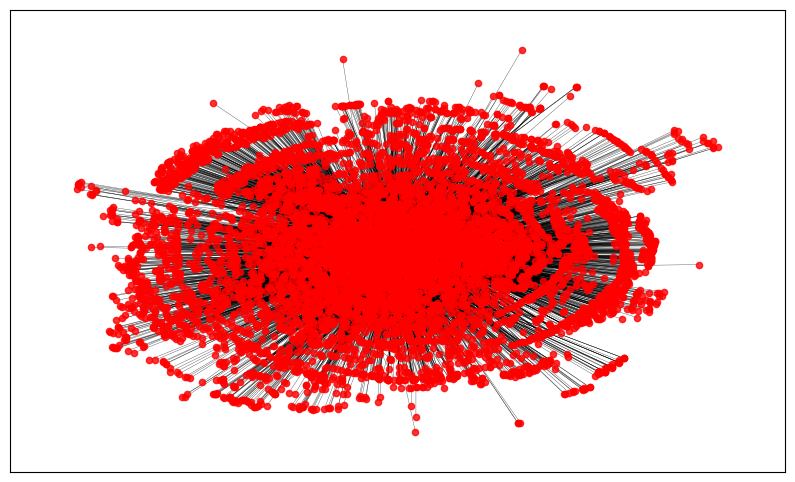

,NombreOrganismo,NombreProveedor,Oferta seleccionada
6462,FUERZA AEREA DE CHILE COMANDO LOGISTICO,Alfredo,1575
8070,I MUNICIPALIDAD DE ARICA,ARICA,1400
1275,COMANDO DE APOYO A LA FUERZA,PS Vial,1151
21115,METRO S.A.,cecilia antonia,1122
11272,I MUNICIPALIDAD DE LA PINTANA,comercializadora perez espinoza,1110
...,...,...,...
12630,I MUNICIPALIDAD DE MAIPU,Olivia Rosa Miranda Avilez E.I.R.L.,1
12631,I MUNICIPALIDAD DE MAIPU,Oscar Hernan,1
12632,I MUNICIPALIDAD DE MAIPU,PANEX SPA,1
12634,I MUNICIPALIDAD DE MAIPU,PIAMONTE S.A.,1


In [178]:
dd10,Gd10 = comunidad(pivot, d[3])
dd10.sort_values(by='Oferta seleccionada', ascending=False)

In [183]:
partition = community_louvain.best_partition(Gd10, weight='Oferta seleccionada', random_state = 6)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Se detectan 17 comunidades


Tamaño Comunidad 0: 437
Tamaño Comunidad 1: 599
Tamaño Comunidad 2: 924
Tamaño Comunidad 3: 244
Tamaño Comunidad 4: 452
Tamaño Comunidad 5: 1591
Tamaño Comunidad 6: 322
Tamaño Comunidad 7: 700
Tamaño Comunidad 8: 472
Tamaño Comunidad 9: 523
Tamaño Comunidad 10: 282
Tamaño Comunidad 11: 281
Tamaño Comunidad 12: 336
Tamaño Comunidad 13: 407
Tamaño Comunidad 14: 352
Tamaño Comunidad 15: 48
Tamaño Comunidad 16: 168


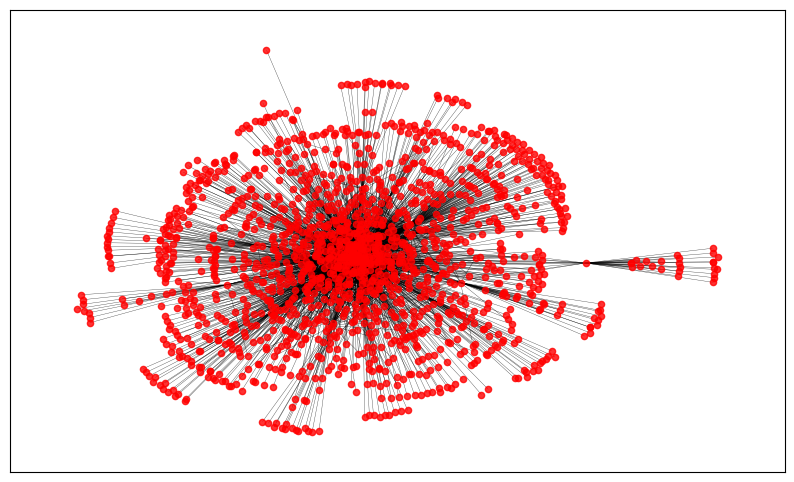

,NombreOrganismo,NombreProveedor,Oferta seleccionada
1211,I MUNICIPALIDAD DE LA PINTANA,comercializadora perez espinoza,1110
35,Hospital Sanatorio San José de Maipo,Centro Comercial Vicuña Mackenna Ltda,668
1087,I MUNICIPALIDAD DE LA PINTANA,MANQUEHUE,635
32,Hospital Sanatorio San José de Maipo,COMERCIAL DF SPA,588
2353,I MUNICIPALIDAD DE TALAGANTE,WOODYS LIMITADA,492
...,...,...,...
1651,I MUNICIPALIDAD DE PUENTE ALTO,Comercializadora Tempora,1
1650,I MUNICIPALIDAD DE PUENTE ALTO,Comercializadora KRK,1
1649,I MUNICIPALIDAD DE PUENTE ALTO,Comercializadora ICEBERG Limitad,1
1641,I MUNICIPALIDAD DE PUENTE ALTO,Colores y Tintas SPA,1


In [184]:
dd11,Gd11 = comunidad(pivot, d[5])
dd11.sort_values(by='Oferta seleccionada', ascending=False)

In [185]:
partition = community_louvain.best_partition(Gd11, weight='Oferta seleccionada', random_state = 6)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Se detectan 19 comunidades


Tamaño Comunidad 0: 67
Tamaño Comunidad 1: 54
Tamaño Comunidad 2: 62
Tamaño Comunidad 3: 127
Tamaño Comunidad 4: 101
Tamaño Comunidad 5: 82
Tamaño Comunidad 6: 125
Tamaño Comunidad 7: 150
Tamaño Comunidad 8: 75
Tamaño Comunidad 9: 86
Tamaño Comunidad 10: 36
Tamaño Comunidad 11: 43
Tamaño Comunidad 12: 116
Tamaño Comunidad 13: 120
Tamaño Comunidad 14: 48
Tamaño Comunidad 15: 116
Tamaño Comunidad 16: 58
Tamaño Comunidad 17: 62
Tamaño Comunidad 18: 63


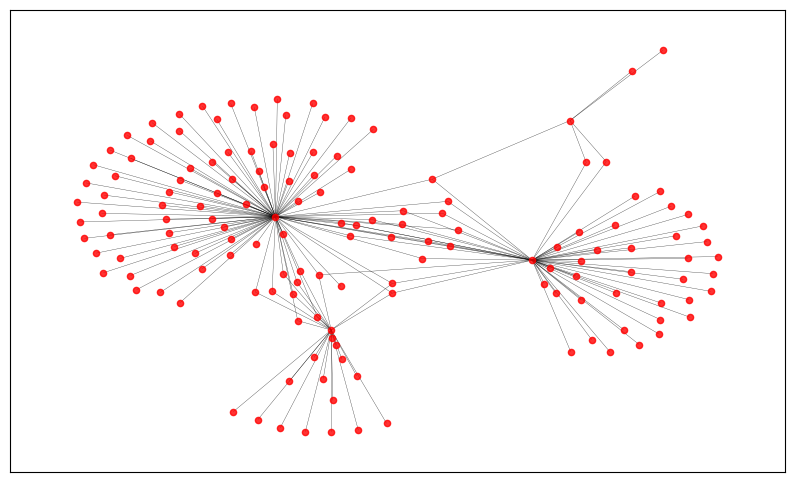

,NombreOrganismo,NombreProveedor,Oferta seleccionada
159,I MUNICIPALIDAD DE MEJILLONES,IRMA,180
176,I MUNICIPALIDAD DE MEJILLONES,inversiones pukara ltda,37
156,I MUNICIPALIDAD DE MEJILLONES,Eduardo Ricardo,19
161,I MUNICIPALIDAD DE MEJILLONES,KSLTDA,19
154,I MUNICIPALIDAD DE MEJILLONES,CASA MATRIZ,18
...,...,...,...
112,I MUNICIPALIDAD DE LA GRANJA,Marco Arturo,1
111,I MUNICIPALIDAD DE LA GRANJA,MIGUEL ANGEL SORIANO BELTRAN,1
110,I MUNICIPALIDAD DE LA GRANJA,MENAJE EL VOLCAN,1
49,I MUNICIPALIDAD DE LA COMUNA DE EL BOSQUE,SIGCON,1


In [186]:
dd12,Gd12 = comunidad(pivot, d[7])
dd12.sort_values(by='Oferta seleccionada', ascending=False)

In [187]:
partition = community_louvain.best_partition(Gd12, weight='Oferta seleccionada', random_state = 6)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))
print('\n')

d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

for i in range(len(d)):
    print(f'Tamaño Comunidad {i}: {len(d[i])}')

Se detectan 4 comunidades


Tamaño Comunidad 0: 6
Tamaño Comunidad 1: 49
Tamaño Comunidad 2: 68
Tamaño Comunidad 3: 27


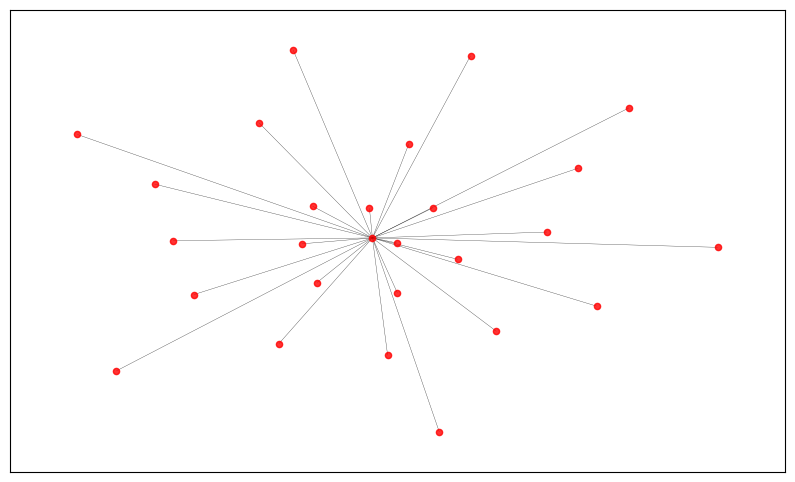

,NombreOrganismo,NombreProveedor,Oferta seleccionada
8,I MUNICIPALIDAD DE MEJILLONES,IRMA,180
25,I MUNICIPALIDAD DE MEJILLONES,inversiones pukara ltda,37
5,I MUNICIPALIDAD DE MEJILLONES,Eduardo Ricardo,19
10,I MUNICIPALIDAD DE MEJILLONES,KSLTDA,19
3,I MUNICIPALIDAD DE MEJILLONES,CASA MATRIZ,18
23,I MUNICIPALIDAD DE MEJILLONES,Unidad Productora Hoppmann,13
6,I MUNICIPALIDAD DE MEJILLONES,Ernesto Perez,11
17,I MUNICIPALIDAD DE MEJILLONES,OZONO Chile,11
24,I MUNICIPALIDAD DE MEJILLONES,carla susana,4
15,I MUNICIPALIDAD DE MEJILLONES,Luis Andres,4


In [188]:
dd13,Gd13 = comunidad(pivot, d[3])
dd13.sort_values(by='Oferta seleccionada', ascending=False)

In [193]:
codigos13 = jaccard_completo(dd13)
codigos13[codigos13['CantidadCoincidencias']>0.2*codigos13['CantidadCoincidencias'].max()]

,NombreProveedor_1,NombreProveedor_2,Coeficiente de Jaccard,CantidadCoincidencias
21,KSLTDA,Eduardo Ricardo,0.07,18
24,CASA MATRIZ,Eduardo Ricardo,0.05,22
26,"Estalista, Materiales Educativos",LADOVERDE,0.04,11
27,CASA MATRIZ,KSLTDA,0.04,13
30,"Estalista, Materiales Educativos",Servicom SpA,0.03,6
